In [1]:
from __future__ import division
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
%matplotlib inline

In [5]:
def initialize(filename="titanic4real.csv", pclass_change=True):

    data = pd.read_csv(filename)
    data.drop(["Name", "Ticket", "Cabin", "Boat", "Body", "home.dest"], axis=1, inplace=True)
    data.dropna(inplace=True)
    data.loc[data.Sex=="female", "Sex"] = 0
    data.loc[data.Sex=="male", "Sex"] = 1
    data.loc[data.Embarked=='S', 'Embarked'] = 0
    data.loc[data.Embarked=='C', 'Embarked'] = 1
    data.loc[data.Embarked=='Q', 'Embarked'] = 2
    
    if pclass_change is True:
        pclass = data["Pclass"]
        data["SecondClass"] = [1 if 2==pclass[i] else 0 for i in pclass.index]
        data["FirstClass"] = [1 if 1==pclass[i] else 0 for i in pclass.index]
        data.drop("Pclass", axis=1, inplace=True)
    
    test_index = sorted(np.random.choice(data.index, int(len(data.index)*.4), replace=False))
    train_index = [i for i in data.index if i not in test_index]
    
    return data.loc[train_index], data.loc[test_index]

utraining, utesting = initialize(pclass_change=False)
ctraining, ctesting = initialize(pclass_change=True)

ctesting

,Survived,Sex,Age,Sibsp,Parch,Fare,Embarked,SecondClass,FirstClass
0,1,0,29.0000,0,0,211.3375,0,0,1
2,0,0,2.0000,1,2,151.5500,0,0,1
4,0,0,25.0000,1,2,151.5500,0,0,1
7,0,1,39.0000,0,0,0.0000,0,0,1
10,0,1,47.0000,1,0,227.5250,1,0,1
18,1,0,32.0000,0,0,76.2917,1,0,1
19,0,1,36.0000,0,0,75.2417,1,0,1
21,1,0,47.0000,1,1,52.5542,0,0,1
23,1,0,42.0000,0,0,227.5250,1,0,1
24,1,0,29.0000,0,0,221.7792,0,0,1


In [6]:
def best_tau(predicted_labels, true_labels, n_tau=100, plot=True):
    """
    Parameters:
        predicted_labels ((n,) ndarray): The predicted probabilities for the data.
        true_labels ((n,) ndarray): The actual labels for the data.
    n_tau (int): The number of values to try for tau.
    plot (bool): Whether or not to plot the roc curve.

    Returns:
        best_tau (float): The optimal value for tau for the data.
    """
    
    tau_space = np.linspace(0,1,n_tau)
    
    def accuracy(tau):
        
        TP = np.sum((predicted_labels >= tau)*true_labels)
        FP = np.sum((predicted_labels >= tau)*true_labels)
        TN = np.sum((predicted_labels < tau)*true_labels)
        FN = np.sum((predicted_labels < tau)*true_labels)
        
        TPR = TP / (TP + FN)
        FPR = FP / (FP + TN)
        
        return TPR - FPR
    
    points = [accuracy(t) for t in tau_space]
    if plot:
        plt.plot(tau_space,points)
        plt.show()
    
    return tau_space[np.argmax(points)]

def auc_scores(unchanged_logreg, changed_logreg, unchanged_bayes, changed_bayes,plot=False):
    """
    Parameters
    ----------
    unchanged_logreg : float in (0,1)
    The value to use for C in the unchanged model
    changed_logreg : float in (0,1)
    The value to use for C in the changed model
    Returns
    -------
    unchanged_auc : float
    The auc for the unchanged model
    changed_auc : float
    The auc for the changed model
    """
    
    unchanged_labels = utraining["Survived"]
    unchanged_data = utraining.drop("Survived", axis=1)
    changed_labels = ctraining["Survived"]
    changed_data = ctraining.drop("Survived", axis=1)
    unchanged_test_labels = utesting["Survived"]
    unchanged_test_data = utesting.drop("Survived", axis=1)
    changed_test_labels = ctesting["Survived"]
    changed_test_data = ctesting.drop("Survived", axis=1)  
    
    lr_unchanged = LogisticRegression(C=unchanged_logreg)
    lr_changed = LogisticRegression(C=changed_logreg)
    nb_unchanged = MultinomialNB(alpha=unchanged_bayes)
    nb_changed = MultinomialNB(alpha=changed_bayes)
    lr_unchanged.fit(unchanged_data, unchanged_labels)
    lr_changed.fit(changed_data, changed_labels)
    nb_unchanged.fit(unchanged_data, unchanged_labels)
    nb_changed.fit(changed_data, changed_labels)
    lr_unchanged_prob = lr_unchanged.predict_proba(unchanged_test_data)
    lr_changed_prob = lr_changed.predict_proba(changed_test_data)
    nb_unchanged_prob = nb_unchanged.predict_proba(unchanged_test_data)
    nb_changed_prob = nb_changed.predict_proba(changed_test_data)

    u_lr_FPR, u_lr_TPR, _ = roc_curve(unchanged_test_labels, lr_unchanged_prob[:,1], pos_label=1)
    c_lr_FPR, c_lr_TPR, _ = roc_curve(changed_test_labels, lr_changed_prob[:,1], pos_label=1)
    u_nb_FPR, u_nb_TPR, _ = roc_curve(unchanged_test_labels, nb_unchanged_prob[:,1], pos_label=1)
    c_nb_FPR, c_nb_TPR, _ = roc_curve(changed_test_labels, nb_changed_prob[:,1], pos_label=1)
    
    # Plot for testing
    if plot is True:
        plt.plot(u_lr_FPR, u_lr_TPR, label="Unchanged Logistic Regression")
        plt.plot(c_lr_FPR, c_lr_TPR, label="Changed Logistic Regression")
        plt.plot(u_nb_FPR, u_nb_TPR, label="Unchanged Naive Bayes")
        plt.plot(c_nb_FPR, c_nb_TPR, label="Changed Naive Bayes")
        plt.legend(loc="lower right")
        plt.ylabel("True")
        plt.xlabel("False")
        plt.show()

    return auc(u_lr_FPR, u_lr_TPR), auc(c_lr_FPR, c_lr_TPR), auc(u_nb_FPR, u_nb_TPR), auc(c_nb_FPR, c_nb_TPR)

def find_best_parameters(n):
    """Find the best parameters!
    
    Parameters:
        The number of values to try for C and alpha.
    
    Returns:
        best (list): The best values of C for the unchanged and changed logistic regression models,
            and the best values of alpha for the unchanged and changed Naive Bayes models.
    """
    
    domain = np.linspace(0,1,n+2)[1:-1]
    best = np.zeros(4)
    
    for d in domain:
        
        attempt = np.array(auc_scores(d,d,d,d,plot=False))
        best = np.max(np.row_stack((attempt, best)), axis=0)
        
    return list(best)

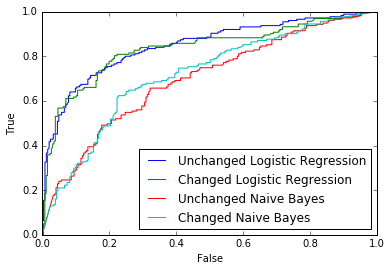

('Parameters:', [0.84763872491145231, 0.83401113531832483, 0.69684769775678879, 0.71677559912854028])
('Scores', (0.84711924439197173, 0.83389009924957624, 0.69677685950413215, 0.71677559912854028))


In [7]:
params = find_best_parameters(100)
scores = auc_scores(*params,plot=True)
print ("Parameters:",params)
print ("Scores",scores)